In [130]:
# Packages have to go in this order... I don't know why

import numpy as np
import pandas as pd
import xarray as xr
import eofs
from eofs.standard import Eof
import glob



# #. you need intake-esm V 2020.11.4 and intake V 0.6.0

# import tensorflow as tf

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from shapely.geometry.polygon import LinearRing


import matplotlib as mpl
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from matplotlib import cm

import copy
import fsspec
import pop_tools
import intake
import scipy.stats
from IPython.display import Image 


## Get Land Mask 
This is usefeul for later when we plot skill/ composites 

In [2]:
# My hacky solution to get around their bullshit
filly = '/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/LANDFRAC/b.e11.B1850C5CN.f09_g16.005.cam.h0.LANDFRAC.040001-049912.nc'
grid = xr.open_dataset(filly)
LM = grid.sel(lat=slice(15,90),lon=slice(170,315))
LM = np.array(LM['LANDFRAC'][0,:,:])
LM[LM==0]=np.nan
# landmask = grid.landmask.load()
# landmask = np.array(landmask.sel(lat=slice(15,90),lon=slice(170,315)))

## Implement the Johnson et al (2014) method for 3-4 week forecasts

Skillful Wintertime North American Temperature Forecasts out to 4 Weeks Based on the State of ENSO and the MJO

https://journals.ametsoc.org/view/journals/wefo/29/1/waf-d-13-00102_1.xml

## Load MJO and ENSO

In [3]:
DSn34=xr.open_dataset('/glade/work/wchapman/ASP_summerschool/datasets/NINO34_monthly_500_999.nc')
mjofils = sorted(glob.glob('/glade/work/wchapman/ASP_summerschool/datasets/MJO/*.nc'))
DSmjo=xr.open_mfdataset(mjofils,combine='by_coords')

In [4]:
DSmjo

<xarray.Dataset>
Dimensions:    (time: 182500)
Coordinates:
  * time       (time) object 0500-01-01 00:00:00 ... 0999-12-31 00:00:00
Data variables:
    MJO_INDEX  (time) float64 dask.array<chunksize=(36500,), meta=np.ndarray>
    PC1        (time) float64 dask.array<chunksize=(36500,), meta=np.ndarray>
    PC2        (time) float64 dask.array<chunksize=(36500,), meta=np.ndarray>

## Open Anomaly Dataset 

In [5]:
Anoms_weekly =xr.open_dataset('/glade/work/wchapman/ASP_summerschool/datasets/weekly_North_America_LENS_CTRL_anom_PSL_TS_PRECL_500_999.nc')

In [7]:
def is_feb(month):
    return (month==1)

ds =Anoms_weekly
monthly_data = ds.sel(time=is_feb(ds['time.month']))
FebT = np.array(monthly_data['TS']).squeeze()


In [8]:
#MJO pandas data frame
DFmjo =pd.DataFrame({'Month':DSmjo['time.month'].data,'Year':DSmjo['time.year'].data,'Day':DSmjo['time.day'].data,'MJO_INDEX':np.array(DSmjo['MJO_INDEX']),'MJO_PC1':np.array(DSmjo['PC1']),'MJO_PC2':np.array(DSmjo['PC2'])})
DFmjo.head(10)

,Month,Year,Day,MJO_INDEX,MJO_PC1,MJO_PC2
0,1,500,1,NaN,NaN,NaN
1,1,500,2,NaN,NaN,NaN
2,1,500,3,NaN,NaN,NaN
3,1,500,4,NaN,NaN,NaN
4,1,500,5,NaN,NaN,NaN
5,1,500,6,NaN,NaN,NaN
6,1,500,7,NaN,NaN,NaN
7,1,500,8,NaN,NaN,NaN
8,1,500,9,NaN,NaN,NaN
9,1,500,10,NaN,NaN,NaN


## Get the Phase of the MJO_Index 

"eight phases that are divided evenly and each occupies 45° on the RMM phase diagram. The angle is defined by the arctangent of RMM2 over RMM1 in degrees and a negative value is converted to positive by adding 360°. As an example, phase 1 is located in the half-open range of (180°, 225°]. The RMM1 is generally nonzero so all angles are defined."

from IPython.display import Image 
Image(url='https://rmets.onlinelibrary.wiley.com/cms/asset/104802a6-dc1f-4176-9705-03cfbb34ad3e/met1780-fig-0004-m.jpg')

As a reminder this image shows the phases vs locations in PC space 

In [135]:
Image(url='https://rmets.onlinelibrary.wiley.com/cms/asset/104802a6-dc1f-4176-9705-03cfbb34ad3e/met1780-fig-0004-m.jpg', width=600)


In [127]:
%%time
MJO_phase = []

for ii in range(DFmjo.shape[0]):
    MJO_INDEX = DFmjo.iloc[ii]['MJO_INDEX']
    RMM1 = DFmjo.iloc[ii]['MJO_PC1']
    RMM2 = DFmjo.iloc[ii]['MJO_PC2']
    
    
    if np.isnan(MJO_INDEX):
        MJO_phase.append(np.nan)
    elif MJO_INDEX < 1:
        MJO_phase.append(0)
    else:
        ang = np.degrees(np.arctan2(RMM2,RMM1))
        if ang<0:
            ang = ang+360
        ang = ang+180 

        if ang > 360:
            ang=ang-360
            
        MJO_phase.append(np.floor((ang)/45)+1)
        
        
DFmjo['MJO_Phase']=MJO_phase
DFmjo.head(10)

CPU times: user 1min 3s, sys: 38.8 ms, total: 1min 3s
Wall time: 1min 3s


,Month,Year,Day,MJO_INDEX,MJO_PC1,MJO_PC2,MJO_Phase
0,1,500,1,NaN,NaN,NaN,NaN
1,1,500,2,NaN,NaN,NaN,NaN
2,1,500,3,NaN,NaN,NaN,NaN
3,1,500,4,NaN,NaN,NaN,NaN
4,1,500,5,NaN,NaN,NaN,NaN
5,1,500,6,NaN,NaN,NaN,NaN
6,1,500,7,NaN,NaN,NaN,NaN
7,1,500,8,NaN,NaN,NaN,NaN
8,1,500,9,NaN,NaN,NaN,NaN
9,1,500,10,NaN,NaN,NaN,NaN


## Create a Pandas DataFrame to Drive the Forecasts

In [140]:
%%time
#pandas data frame
DFalltimes = pd.DataFrame({'Year':Anoms_weekly['time.year'],'Month':Anoms_weekly['time.month'],'Day':Anoms_weekly['time.day']})

DFforecast = pd.DataFrame({'Year':Anoms_weekly['time.year'],'Month':Anoms_weekly['time.month'],'Day':Anoms_weekly['time.day']})
print('intermediate dataframe:')
print(DFforecast.head(10))

#ENSO pandas data frame
DFenso =pd.DataFrame({'Month':DSn34['time.month'].data,'Year':DSn34['time.year'].data,'ENSO':np.array(DSn34['Nino34'])})
DFenso.head(10)

#MJO pandas data frame
DFenso =pd.DataFrame({'Month':DSn34['time.month'].data,'Year':DSn34['time.year'].data,'ENSO':np.array(DSn34['Nino34'])})
DFenso.head(10)



print('...building ENSO in DFforecast...')

ENSOind = []
MJOind = []
for bb in range(DFforecast.shape[0]):
    mo = DFforecast.Month[bb]
    yr = DFforecast.Year[bb]
    ENSOind.append(np.array(DFenso[(DFenso['Month']==mo)&(DFenso['Year']==yr)]['ENSO'])[0])
    
print('...building MJO in DFforecast...')
MJOind = []
PC1ind = []
PC2ind = []
MJOphase = []
for bb in range(DFforecast.shape[0]):
    mo = DFforecast.Month[bb]
    yr = DFforecast.Year[bb]
    dy = DFforecast.Day[bb]
    
    indy = DFmjo[(DFmjo['Month']==mo)&(DFmjo['Year']==yr)&(DFmjo['Day']==dy)].index
    
    MJOind.append(np.array(DFmjo.loc[indy,:]['MJO_INDEX'])[0])
    PC1ind.append(np.array(DFmjo.loc[indy,:]['MJO_PC1'])[0])
    PC2ind.append(np.array(DFmjo.loc[indy,:]['MJO_PC2'])[0])
    MJOphase.append(np.array(DFmjo.loc[indy,:]['MJO_Phase'])[0])
    
    
DFforecast['ENSO']=ENSOind
DFforecast['MJO_INDEX']=MJOind
DFforecast['MJO_PC1']=PC1ind
DFforecast['MJO_PC2']=PC2ind
DFforecast['MJO_Phase']=MJOphase


DFforecast.head(10)


intermediate dataframe:
   Year  Month  Day
0   500      1    1
1   500      1    8
2   500      1   15
3   500      1   22
4   500      1   29
5   500      2    5
6   500      2   12
7   500      2   19
8   500      2   26
9   500      3    5
...building ENSO in DFforecast...
...building MJO in DFforecast...
CPU times: user 1min 49s, sys: 66.1 ms, total: 1min 49s
Wall time: 1min 49s


,Year,Month,Day,ENSO,MJO_INDEX,MJO_PC1,MJO_PC2,MJO_Phase
0,500,1,1,0.865147,NaN,NaN,NaN,NaN
1,500,1,8,0.865147,NaN,NaN,NaN,NaN
2,500,1,15,0.865147,NaN,NaN,NaN,NaN
3,500,1,22,0.865147,NaN,NaN,NaN,NaN
4,500,1,29,0.865147,NaN,NaN,NaN,NaN
5,500,2,5,1.108327,NaN,NaN,NaN,NaN
6,500,2,12,1.108327,NaN,NaN,NaN,NaN
7,500,2,19,1.108327,NaN,NaN,NaN,NaN
8,500,2,26,1.108327,NaN,NaN,NaN,NaN
9,500,3,5,1.231840,NaN,NaN,NaN,NaN


## Get The Lagged Predictor Field

Set the variable "Lead" to determine the specified "lead - time" 

In [141]:
%%time
Lead=3
forecastMonth=[]
forecastYear=[]
forecastDay=[]
ind_forecast=[]
print('...diving in....')
for ii in range(DFforecast.shape[0]):
    mo = DFforecast['Month'][ii]
    yr = DFforecast['Year'][ii]
    da = DFforecast['Day'][ii]
    leadind =  DFforecast[(DFalltimes['Month']==mo)&(DFalltimes['Year']==yr)&(DFalltimes['Day']==da)].index[0]+Lead
    
    if leadind < DFalltimes.shape[0]:
        forecastMonth.append(DFalltimes['Month'][leadind])
        forecastDay.append(DFalltimes['Day'][leadind])
        forecastYear.append(DFalltimes['Year'][leadind])
    else: 
        print('....done...?')
        forecastMonth.append(-999)
        forecastDay.append(-999)
        forecastYear.append(-999)
        
    
    if leadind >= DFalltimes.shape[0]:
        ind_forecast.append(-999)
    elif (DFforecast[(DFforecast['Month']==DFalltimes['Month'][leadind]) & (DFforecast['Day']==DFalltimes['Day'][leadind]) & (DFforecast['Year']==DFalltimes['Year'][leadind])].shape[0] ==0):
        ind_forecast.append(-999)
    elif DFforecast[(DFforecast['Month']==DFalltimes['Month'][leadind]) & (DFforecast['Day']==DFalltimes['Day'][leadind]) & (DFforecast['Year']==DFalltimes['Year'][leadind])].shape[0] ==1:
        ind_forecast.append(DFforecast[(DFforecast['Month']==DFalltimes['Month'][leadind]) & (DFforecast['Day']==DFalltimes['Day'][leadind]) & (DFforecast['Year']==DFalltimes['Year'][leadind])].index[0])
    else:
        print('ohhh shit')
        
#append this to the data forecast. 
DFforecast['Month_3lead'] = forecastMonth
DFforecast['Year_3lead'] = forecastYear
DFforecast['Day_3lead'] = forecastDay
DFforecast['Ind_3lead'] = ind_forecast

#drop any forecasts verifying in april. Remove from ALLL datasets. ~ 5400 forecasts. 
verifApril = DFforecast[DFforecast['Month_3lead']==4].index
DFforecast.iloc[verifApril]

...diving in....
....done...?
....done...?
....done...?
CPU times: user 2min 28s, sys: 169 ms, total: 2min 28s
Wall time: 2min 28s


,Year,Month,Day,ENSO,MJO_INDEX,MJO_PC1,MJO_PC2,MJO_Phase,Month_3lead,Year_3lead,Day_3lead,Ind_3lead
10,500,3,12,1.231840,NaN,NaN,NaN,NaN,4,500,2,13
11,500,3,19,1.231840,NaN,NaN,NaN,NaN,4,500,9,14
12,500,3,26,1.231840,NaN,NaN,NaN,NaN,4,500,16,15
13,500,4,2,0.992653,NaN,NaN,NaN,NaN,4,500,23,16
14,500,4,9,0.992653,NaN,NaN,NaN,NaN,4,500,30,17
...,...,...,...,...,...,...,...,...,...,...,...,...
25981,998,4,8,-0.414753,0.474075,0.326683,0.606096,0.0,4,998,29,25984
26030,999,3,17,0.478185,2.933832,-0.765911,1.532061,7.0,4,999,7,26033
26031,999,3,24,0.478185,1.075506,0.367455,0.969785,6.0,4,999,14,26034
26032,999,3,31,0.478185,5.503664,2.299232,0.466040,5.0,4,999,21,26035


## Drop Rows with NaN values
Then show how many independent predictors we have remaining 

In [142]:
DFforecast= DFforecast.dropna()

print('The predictor space has ',DFforecast.shape[0],' samples with',np.unique(DFforecast['Year']).shape[0],'years to cross-validate on' )

The predictor space has  25928  samples with 500 years to cross-validate on


## Lets subset for winter months
forecasts initialized in Dec - > Feb. 

In [146]:
DFforecast_DJFM = DFforecast[(DFforecast['Month']==12)|(DFforecast['Month']==1)|(DFforecast['Month']==2)] 
forecastindices = DFforecast_DJFM.index
verificationindices =DFforecast_DJFM['Ind_3lead']

print('The predictor space has ',DFforecast_DJFM.shape[0],' samples with',np.unique(DFforecast_DJFM['Year']).shape[0],'years to cross-validate on' )
DFforecast_DJFM.head(45)

The predictor space has  6365  samples with 500 years to cross-validate on


,Year,Month,Day,ENSO,MJO_INDEX,MJO_PC1,MJO_PC2,MJO_Phase,Month_3lead,Year_3lead,Day_3lead,Ind_3lead
48,500,12,3,3.061497,11.958813,2.945192,1.812362,5.0,12,500,24,51
49,500,12,10,3.061497,6.388230,1.981869,-1.568574,4.0,12,500,31,52
50,500,12,17,3.061497,8.152002,-2.099707,-1.934744,1.0,1,501,7,53
51,500,12,24,3.061497,1.098555,-0.937496,0.468674,8.0,1,501,14,54
52,500,12,31,3.061497,2.419562,1.308457,-0.841132,4.0,1,501,21,55
53,501,1,7,3.076489,6.192405,-1.489924,-1.993121,2.0,1,501,28,56
54,501,1,14,3.076489,7.524376,-2.285328,1.517119,8.0,2,501,4,57
55,501,1,21,3.076489,4.195137,0.787272,1.890857,6.0,2,501,11,58
56,501,1,28,3.076489,3.422154,1.310144,-1.306016,4.0,2,501,18,59
57,501,2,4,2.903291,0.947327,0.694840,-0.681561,0.0,2,501,25,60


## Get the Tercile Values for Everypoint for every point 
## Run the Forecast for 1 point 
First subset for only the winter months?? 

## Plot NINO anomaly. 

In [169]:
Ninoind = np.array(DFforecast_DJFM[DFforecast_DJFM['MJO_Phase']==5]['Ind_3lead'])
TS = np.array(Anoms_weekly['TS']).squeeze()
#get all of our indices"
lat = np.array(Anoms_weekly['lat'])
lon = np.array(Anoms_weekly['lon'])

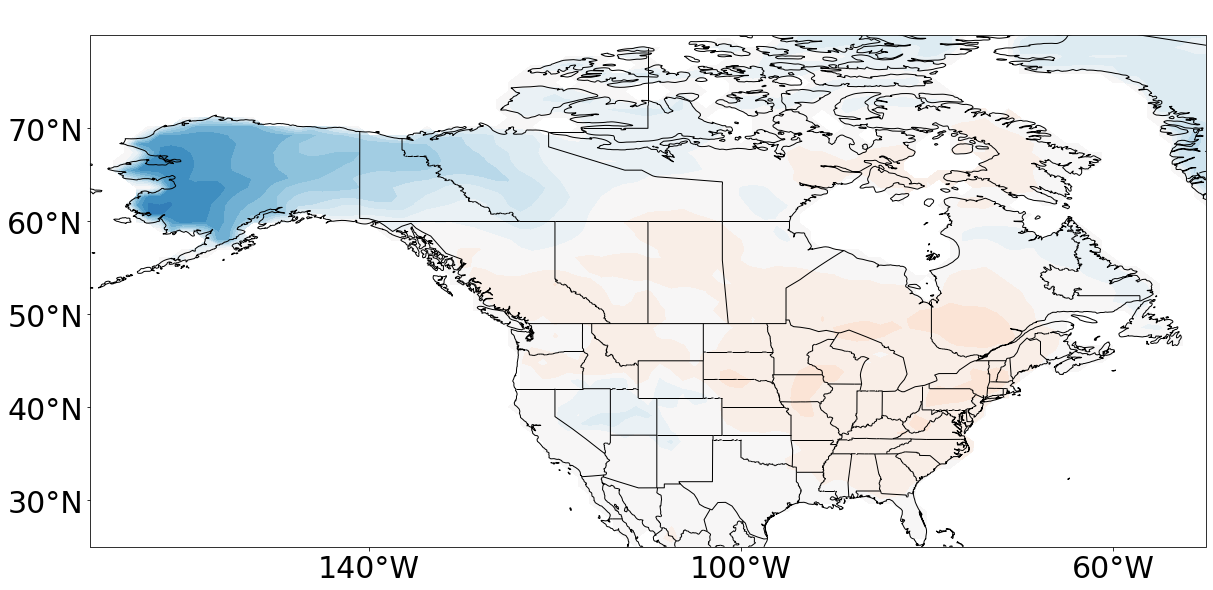

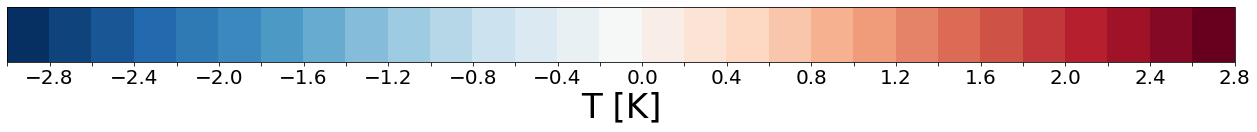

In [170]:
plot_field= np.mean(TS[Ninoind,:,:],axis=0).squeeze()*LM

plt.figure(figsize=(20, 20))
proj = ccrs.PlateCarree(central_longitude=180)
ax1 = plt.subplot(1, 1, 1, projection=proj)
ax1.coastlines('50m')

clevsHSS=np.arange(-3,3,0.2) 

haa = cm.get_cmap("Greys",len(clevsHSS))
haa = haa(np.linspace(0,1,len(clevsHSS)))
white=[1,1,1,1]
haa[:3,:] = white

#either do this 
cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))

#or set an ocean nanmask! 
nanmask = np.zeros_like(plot_field)+1


plt.contourf(lon-180, lat, (plot_field),levels=clevsHSS,
            cmap=cmap, transform=proj)


plt.plot([120-180,300-180],[0,0],color='k',linewidth=1,linestyle='--',zorder=1)

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')

ax1.set_xticks([100,140,180,220,260,300,340], crs=ccrs.PlateCarree())
ax1.set_yticks(np.arange(-10,80,10), crs=ccrs.PlateCarree())

lon_formatter = LongitudeFormatter(zero_direction_label=True,number_format='.0f')
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.tick_params(labelsize=30) 
ax1.set_extent([190,310,25,80], crs=ccrs.PlateCarree())
ax1.add_feature(states_provinces, edgecolor='black')
ax1.add_feature(cartopy.feature.BORDERS,edgecolor='black')
plt.title(' ',fontsize=30)
plt.show()


# ############################################################################################
#                                         ####colorbar#####
# ############################################################################################
fig, ax = plt.subplots(figsize=(22, 2))
fig.subplots_adjust(bottom=0.5)

#set these features the same as above. 
cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))
bounds=clevsHSS

norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal', extend='neither',
                                ticks=bounds)


cb2.ax.tick_params(labelsize=20) 
for label in cb2.ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
cb2.set_label('T [K]',fontsize=34) 
plt.show()


## Get Mean and Varianace
calculate mean and variance for 8 MJO states ('Weak/Strong') & 3 ENSO states (Nina / Neutral / Nino) for every point in the domain

In [198]:
T2m_Mean_mjo = np.zeros([2,lat.shape[0],lon.shape[0]])

Ninoind = np.array(DFforecast_DJFM[DFforecast_DJFM['ENSO']>1].index)
Ninaind = np.array(DFforecast_DJFM[DFforecast_DJFM['ENSO']<-1].index)
Neutind = np.array(DFforecast_DJFM[(DFforecast_DJFM['ENSO']>-1) & (DFforecast_DJFM['ENSO']<1)].index)

MJOthresh = 1
ENSOthresh = 1

# T2m_Mean_mjo = np.mean()

Forecast = []
Verif = []

for ii,yrs in enumerate(np.unique(DFforecast_DJFM['Year'])):
    print(yrs)
    
    Training_inds = np.array(DFforecast_DJFM[(DFforecast_DJFM['Year']!=yrs)&(DFforecast_DJFM['Year']!=yrs+1)].index)
    
    Test_inds = np.array(DFforecast_DJFM[(DFforecast_DJFM['Year']==yrs)|(DFforecast_DJFM['Year']==yrs+1)].index)
    
    Training_mean = np.mean(TS[Training_inds,:,:],axis=0)
    Training_std = np.std(TS[Training_inds,:,:],axis=0)
    
    Ninoind = DFforecast_DJFM[(DFforecast_DJFM['ENSO']>ENSOthresh)&(DFforecast_DJFM['Year']!=yrs)&(DFforecast_DJFM['Year']!=yrs+1)]['Ind_3lead']
    Ninaind = DFforecast_DJFM[(DFforecast_DJFM['ENSO']<-ENSOthresh)&(DFforecast_DJFM['Year']!=yrs)&(DFforecast_DJFM['Year']!=yrs+1)]['Ind_3lead']
    Neutind = DFforecast_DJFM[(DFforecast_DJFM['ENSO']>-ENSOthresh) & (DFforecast_DJFM['ENSO']<ENSOthresh)&(DFforecast_DJFM['Year']!=yrs)&(DFforecast_DJFM['Year']!=yrs+1)]['Ind_3lead']
    
    
    
    MJO_0 = DFforecast_DJFM[(DFforecast_DJFM['MJO_Phase']==0)&(DFforecast_DJFM['Year']!=yrs)&(DFforecast_DJFM['Year']!=yrs+1)]['Ind_3lead']
    MJO_1 = DFforecast_DJFM[(DFforecast_DJFM['MJO_Phase']==1)&(DFforecast_DJFM['Year']!=yrs)&(DFforecast_DJFM['Year']!=yrs+1)]['Ind_3lead']
    MJO_2 = DFforecast_DJFM[(DFforecast_DJFM['MJO_Phase']==2)&(DFforecast_DJFM['Year']!=yrs)&(DFforecast_DJFM['Year']!=yrs+1)]['Ind_3lead']
    MJO_3 = DFforecast_DJFM[(DFforecast_DJFM['MJO_Phase']==3)&(DFforecast_DJFM['Year']!=yrs)&(DFforecast_DJFM['Year']!=yrs+1)]['Ind_3lead']
    MJO_4 = DFforecast_DJFM[(DFforecast_DJFM['MJO_Phase']==4)&(DFforecast_DJFM['Year']!=yrs)&(DFforecast_DJFM['Year']!=yrs+1)]['Ind_3lead']
    MJO_5 = DFforecast_DJFM[(DFforecast_DJFM['MJO_Phase']==5)&(DFforecast_DJFM['Year']!=yrs)&(DFforecast_DJFM['Year']!=yrs+1)]['Ind_3lead']
    MJO_6 = DFforecast_DJFM[(DFforecast_DJFM['MJO_Phase']==6)&(DFforecast_DJFM['Year']!=yrs)&(DFforecast_DJFM['Year']!=yrs+1)]['Ind_3lead']
    MJO_7 = DFforecast_DJFM[(DFforecast_DJFM['MJO_Phase']==7)&(DFforecast_DJFM['Year']!=yrs)&(DFforecast_DJFM['Year']!=yrs+1)]['Ind_3lead']
    MJO_8 = DFforecast_DJFM[(DFforecast_DJFM['MJO_Phase']==8)&(DFforecast_DJFM['Year']!=yrs)&(DFforecast_DJFM['Year']!=yrs+1)]['Ind_3lead']
    
    #testing dataframe:
    DF_year = DFforecast_DJFM[(DFforecast_DJFM['Year']==yrs) | (DFforecast_DJFM['Year']==yrs+1) ]
    
    lala = 50
    lolo = 240
    laind = np.argmin(np.abs(lat-lala))
    loind = np.argmin(np.abs(lon-lolo))
    
    
    full_mean=np.mean(TS[Training_inds,laind,loind])
    full_std=np.std(TS[Training_inds,laind,loind])
    
    print('full M/S',full_mean,full_std)
    Nina_mean = np.mean(TS[Ninaind,laind,loind])
    Nino_mean = np.mean(TS[Ninoind,laind,loind])
    Neut_mean = np.mean(TS[Neutind,laind,loind])
    Nina_std = np.std(TS[Ninaind,laind,loind])
    Nino_std = np.std(TS[Ninoind,laind,loind])
    Neut_std = np.std(TS[Neutind,laind,loind])
    
    
    MJO_0_mean = np.mean(TS[MJO_0,laind,loind])
    MJO_1_mean = np.mean(TS[MJO_1,laind,loind])
    MJO_2_mean = np.mean(TS[MJO_2,laind,loind])
    MJO_3_mean = np.mean(TS[MJO_3,laind,loind])
    MJO_4_mean = np.mean(TS[MJO_4,laind,loind])
    MJO_5_mean = np.mean(TS[MJO_5,laind,loind])
    MJO_6_mean = np.mean(TS[MJO_6,laind,loind])
    MJO_7_mean = np.mean(TS[MJO_7,laind,loind])
    MJO_8_mean = np.mean(TS[MJO_8,laind,loind])
    
    MJO_0_std = np.std(TS[MJO_0,laind,loind])
    MJO_1_std = np.std(TS[MJO_1,laind,loind])
    MJO_2_std = np.std(TS[MJO_2,laind,loind])
    MJO_3_std = np.std(TS[MJO_3,laind,loind])
    MJO_4_std = np.std(TS[MJO_4,laind,loind])
    MJO_5_std = np.std(TS[MJO_5,laind,loind])
    MJO_6_std = np.std(TS[MJO_6,laind,loind])
    MJO_7_std = np.std(TS[MJO_7,laind,loind])
    MJO_8_std = np.std(TS[MJO_8,laind,loind])
        
    
    threethree = scipy.stats.norm.ppf(.333333, loc=Training_mean[laind,loind], scale=Training_std[laind,loind])
    sixsix = scipy.stats.norm.ppf(.666666, loc=Training_mean[laind,loind], scale=Training_std[laind,loind])
    
    for yes in range(len(DF_year)): 
        test_MJO = DF_year.iloc[yes]['MJO_Phase']
        test_ENSO = DF_year.iloc[yes]['ENSO']
        index_verif = int(DF_year.iloc[yes]['Ind_3lead'])
        
#         print(test_MJO,test_ENSO)
        #MJO test:
        if test_MJO == 0:
#             print('High MJO')
            MJO_test_mean = MJO_0_mean 
            MJO_test_std = MJO_0_std
        elif test_MJO==1:
            MJO_test_mean = MJO_1_mean 
            MJO_test_std = MJO_1_std
        elif test_MJO==2:
            MJO_test_mean = MJO_2_mean 
            MJO_test_std = MJO_2_std
        elif test_MJO==3:
            MJO_test_mean = MJO_3_mean 
            MJO_test_std = MJO_3_std
        elif test_MJO==4:
            MJO_test_mean = MJO_4_mean 
            MJO_test_std = MJO_4_std
        elif test_MJO==5:
            MJO_test_mean = MJO_5_mean 
            MJO_test_std = MJO_5_std
        elif test_MJO==6:
            MJO_test_mean = MJO_6_mean 
            MJO_test_std = MJO_6_std
        elif test_MJO==7:
            MJO_test_mean = MJO_7_mean 
            MJO_test_std = MJO_7_std
        elif test_MJO==8:
            MJO_test_mean = MJO_8_mean 
            MJO_test_std = MJO_8_std
        else:
            print('..Broken MJO..')
            break
        
        #ENSO test
        if test_ENSO > ENSOthresh:
#             print('High ENSO')
            ENSO_test_mean = Nino_mean
            ENSO_test_std = Nino_std
        elif test_ENSO < -ENSOthresh:
#             print('LOW ENSO')
            ENSO_test_mean = Nina_mean
            ENSO_test_std = Nina_std
        else: 
#             print('Neut ENSO')
            ENSO_test_mean = Neut_mean
            ENSO_test_std = Neut_std
    
        test_mean = ENSO_test_mean + MJO_test_mean
        test_std = np.sqrt(ENSO_test_std**2+ENSO_test_std**2)
        
        print('full M/S',full_mean,full_std)
        print('test M/S:',test_mean,test_std)
        print('33rd, 66th',threethree,sixsix)
        
        percHigh = scipy.stats.norm(test_mean, test_std).sf(sixsix)

        percLow=(1-scipy.stats.norm(test_mean, test_std).sf(threethree))
        
        percNeut = 1 - (1-scipy.stats.norm(test_mean, test_std).sf(threethree)) - scipy.stats.norm(test_mean, test_std).sf(sixsix)
        
        Forecast.append(np.argmax([percLow,percNeut,percHigh]))
        
        
        verif_val = TS[index_verif,laind,loind]
        
        
        verif_all =np.sort([float(verif_val),threethree,sixsix])
        Verif.append(np.where(verif_all==verif_val)[0][0])
#         print('Forecast:',[percLow,percNeut,percHigh])
#         print('Forecast:',np.argmax([percLow,percNeut,percHigh]))
#         verif = /

500
full M/S -0.11665586 6.011275
full M/S -0.11665586 6.011275
test M/S: 0.4364871 7.0558032348591935
33rd, 66th -2.7058817803413495 2.472553862756433
full M/S -0.11665586 6.011275
test M/S: 0.35918942 7.0558032348591935
33rd, 66th -2.7058817803413495 2.472553862756433
full M/S -0.11665586 6.011275
test M/S: -0.267085 7.0558032348591935
33rd, 66th -2.7058817803413495 2.472553862756433
full M/S -0.11665586 6.011275
test M/S: 0.16160452 7.0558032348591935
33rd, 66th -2.7058817803413495 2.472553862756433
full M/S -0.11665586 6.011275
test M/S: 0.35918942 7.0558032348591935
33rd, 66th -2.7058817803413495 2.472553862756433
full M/S -0.11665586 6.011275
test M/S: 0.24805507 7.0558032348591935
33rd, 66th -2.7058817803413495 2.472553862756433
full M/S -0.11665586 6.011275
test M/S: 0.16160452 7.0558032348591935
33rd, 66th -2.7058817803413495 2.472553862756433
full M/S -0.11665586 6.011275
test M/S: 0.12324229 7.0558032348591935
33rd, 66th -2.7058817803413495 2.472553862756433
full M/S -0.1166

KeyboardInterrupt: 

In [173]:
hits =0
for bb in range(len(Verif)):
    hits+=np.sum(Verif[bb] == Forecast[bb])
    
HSS = (hits-(int(len(Verif)*0.3333)))/(len(Verif)-(int(len(Verif)*0.3333)))*100
HSS

-7.06034889203206

In [195]:
np.unique(Forecast[:,:,:])

array([0., 1., 2.])

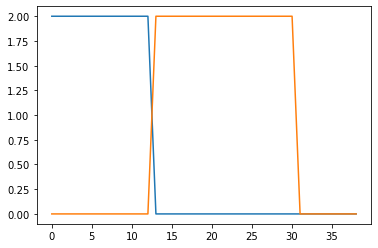

In [194]:
plt.plot(Forecast[:39,60,100])
plt.plot(Forecast[:39,20,20])

In [ ]:
plt.plot(Forecast[:39,60,100])

## All Points at once?

In [174]:
%%time
T2m_Mean_mjo = np.zeros([2,lat.shape[0],lon.shape[0]])

Ninoind = np.array(DFforecast_DJFM[DFforecast_DJFM['ENSO']>1].index)
Ninaind = np.array(DFforecast_DJFM[DFforecast_DJFM['ENSO']<-1].index)
Neutind = np.array(DFforecast_DJFM[(DFforecast_DJFM['ENSO']>-1) & (DFforecast_DJFM['ENSO']<1)].index)

MJOthresh = 5
ENSOthresh = 1

# T2m_Mean_mjo = np.mean()

Forecast = np.zeros([DFforecast_DJFM.shape[0],lat.shape[0],lon.shape[0]])
Verif = np.zeros([DFforecast_DJFM.shape[0],lat.shape[0],lon.shape[0]])
count = 0
for ii,yrs in enumerate(np.unique(DFforecast_DJFM['Year'])[::2]):
    print('year:',yrs)
    
    
    Training_inds = np.array(DFforecast_DJFM[(DFforecast_DJFM['Year']!=yrs)&(DFforecast_DJFM['Year']!=yrs+1)].index)
    Test_inds = np.array(DFforecast_DJFM[(DFforecast_DJFM['Year']==yrs)|(DFforecast_DJFM['Year']==yrs+1)].index)
    
    Training_mean = np.mean(TS[Training_inds,:,:],axis=0)
    Training_std = np.std(TS[Training_inds,:,:],axis=0)
    
    Ninoind = DFforecast_DJFM[(DFforecast_DJFM['ENSO']>ENSOthresh)&(DFforecast_DJFM['Year']!=yrs)&(DFforecast_DJFM['Year']!=yrs+1)]['Ind_3lead']
    Ninaind = DFforecast_DJFM[(DFforecast_DJFM['ENSO']<-ENSOthresh)&(DFforecast_DJFM['Year']!=yrs)&(DFforecast_DJFM['Year']!=yrs+1)]['Ind_3lead']
    Neutind = DFforecast_DJFM[(DFforecast_DJFM['ENSO']>-ENSOthresh) & (DFforecast_DJFM['ENSO']<ENSOthresh)&(DFforecast_DJFM['Year']!=yrs)&(DFforecast_DJFM['Year']!=yrs+1)]['Ind_3lead']
    
    MJO_0 = DFforecast_DJFM[(DFforecast_DJFM['MJO_Phase']==0)&(DFforecast_DJFM['Year']!=yrs)&(DFforecast_DJFM['Year']!=yrs+1)]['Ind_3lead']
    MJO_1 = DFforecast_DJFM[(DFforecast_DJFM['MJO_Phase']==1)&(DFforecast_DJFM['Year']!=yrs)&(DFforecast_DJFM['Year']!=yrs+1)]['Ind_3lead']
    MJO_2 = DFforecast_DJFM[(DFforecast_DJFM['MJO_Phase']==2)&(DFforecast_DJFM['Year']!=yrs)&(DFforecast_DJFM['Year']!=yrs+1)]['Ind_3lead']
    MJO_3 = DFforecast_DJFM[(DFforecast_DJFM['MJO_Phase']==3)&(DFforecast_DJFM['Year']!=yrs)&(DFforecast_DJFM['Year']!=yrs+1)]['Ind_3lead']
    MJO_4 = DFforecast_DJFM[(DFforecast_DJFM['MJO_Phase']==4)&(DFforecast_DJFM['Year']!=yrs)&(DFforecast_DJFM['Year']!=yrs+1)]['Ind_3lead']
    MJO_5 = DFforecast_DJFM[(DFforecast_DJFM['MJO_Phase']==5)&(DFforecast_DJFM['Year']!=yrs)&(DFforecast_DJFM['Year']!=yrs+1)]['Ind_3lead']
    MJO_6 = DFforecast_DJFM[(DFforecast_DJFM['MJO_Phase']==6)&(DFforecast_DJFM['Year']!=yrs)&(DFforecast_DJFM['Year']!=yrs+1)]['Ind_3lead']
    MJO_7 = DFforecast_DJFM[(DFforecast_DJFM['MJO_Phase']==7)&(DFforecast_DJFM['Year']!=yrs)&(DFforecast_DJFM['Year']!=yrs+1)]['Ind_3lead']
    MJO_8 = DFforecast_DJFM[(DFforecast_DJFM['MJO_Phase']==8)&(DFforecast_DJFM['Year']!=yrs)&(DFforecast_DJFM['Year']!=yrs+1)]['Ind_3lead']
    
    
    DF_year = DFforecast_DJFM[(DFforecast_DJFM['Year']==yrs) | (DFforecast_DJFM['Year']==yrs+1) ]
    

    full_mean=np.mean(TS[Training_inds,:,:],axis=0)
    full_std=np.std(TS[Training_inds,:,:],axis=0)
    
#     print('full M/S',full_mean,full_std)
    Nina_mean = np.mean(TS[Ninaind,:,:],axis=0)
    Nino_mean = np.mean(TS[Ninoind,:,:],axis=0)
    Neut_mean = np.mean(TS[Neutind,:,:],axis=0)
    Nina_std = np.std(TS[Ninaind,:,:],axis=0)
    Nino_std = np.std(TS[Ninoind,:,:],axis=0)
    Neut_std = np.std(TS[Neutind,:,:],axis=0)
    
    
    MJO_0_mean = np.mean(TS[MJO_0,:,:],axis=0)
    MJO_1_mean = np.mean(TS[MJO_1,:,:],axis=0)
    MJO_2_mean = np.mean(TS[MJO_2,:,:],axis=0)
    MJO_3_mean = np.mean(TS[MJO_3,:,:],axis=0)
    MJO_4_mean = np.mean(TS[MJO_4,:,:],axis=0)
    MJO_5_mean = np.mean(TS[MJO_5,:,:],axis=0)
    MJO_6_mean = np.mean(TS[MJO_6,:,:],axis=0)
    MJO_7_mean = np.mean(TS[MJO_7,:,:],axis=0)
    MJO_8_mean = np.mean(TS[MJO_8,:,:],axis=0)
    
    MJO_0_std = np.std(TS[MJO_0,:,:],axis=0)
    MJO_1_std = np.std(TS[MJO_1,:,:],axis=0)
    MJO_2_std = np.std(TS[MJO_2,:,:],axis=0)
    MJO_3_std = np.std(TS[MJO_3,:,:],axis=0)
    MJO_4_std = np.std(TS[MJO_4,:,:],axis=0)
    MJO_5_std = np.std(TS[MJO_5,:,:],axis=0)
    MJO_6_std = np.std(TS[MJO_6,:,:],axis=0)
    MJO_7_std = np.std(TS[MJO_7,:,:],axis=0)
    MJO_8_std = np.std(TS[MJO_8,:,:],axis=0)
    
    threethree = scipy.stats.norm.ppf(.333333, loc=Training_mean, scale=Training_std)
    sixsix = scipy.stats.norm.ppf(.666666, loc=Training_mean, scale=Training_std)
    
    for yes in range(len(DF_year)): 
        test_MJO = DF_year.iloc[yes]['MJO_Phase']
        test_ENSO = DF_year.iloc[yes]['ENSO']
        index_verif = int(DF_year.iloc[yes]['Ind_3lead'])
        
#         print(test_MJO,test_ENSO)
    
         #MJO test:
        if test_MJO == 0:
#             print('High MJO')
            MJO_test_mean = MJO_0_mean 
            MJO_test_std = MJO_0_std
        elif test_MJO==1:
            MJO_test_mean = MJO_1_mean 
            MJO_test_std = MJO_1_std
        elif test_MJO==2:
            MJO_test_mean = MJO_2_mean 
            MJO_test_std = MJO_2_std
        elif test_MJO==3:
            MJO_test_mean = MJO_3_mean 
            MJO_test_std = MJO_3_std
        elif test_MJO==4:
            MJO_test_mean = MJO_4_mean 
            MJO_test_std = MJO_4_std
        elif test_MJO==5:
            MJO_test_mean = MJO_5_mean 
            MJO_test_std = MJO_5_std
        elif test_MJO==6:
            MJO_test_mean = MJO_6_mean 
            MJO_test_std = MJO_6_std
        elif test_MJO==7:
            MJO_test_mean = MJO_7_mean 
            MJO_test_std = MJO_7_std
        elif test_MJO==8:
            MJO_test_mean = MJO_8_mean 
            MJO_test_std = MJO_8_std
        else:
            print('..Broken MJO..')
            break
        
        if test_ENSO > ENSOthresh:
#             print('High ENSO')
            ENSO_test_mean = Nino_mean
            ENSO_test_std = Nino_std
        elif test_ENSO < -ENSOthresh:
#             print('LOW ENSO')
            ENSO_test_mean = Nina_mean
            ENSO_test_std = Nina_std
        else: 
#             print('Neut ENSO')
            ENSO_test_mean = Neut_mean
            ENSO_test_std = Neut_std
    
        test_mean = ENSO_test_mean + MJO_test_mean
        test_std = np.sqrt(ENSO_test_std**2+ENSO_test_std**2)
        
#         print('full M/S',full_mean,full_std)
#         print('test M/S:',test_mean,test_std)
#         print('33rd, 66th',threethree,sixsix)
        
        percHigh = scipy.stats.norm(test_mean, test_std).sf(sixsix)

        percLow=(1-scipy.stats.norm(test_mean, test_std).sf(threethree))
        
        percNeut = 1 - (1-scipy.stats.norm(test_mean, test_std).sf(threethree)) - scipy.stats.norm(test_mean, test_std).sf(sixsix)
        
        
        Forecast[count,:,:] = np.argmax(np.concatenate([percLow[None,...],percNeut[None,...],percHigh[None,...]]),axis=0)
        
        verif_val = TS[index_verif,:,:]
        
        
        verif_val = TS[index_verif,:,:]

        full_verif3366 = np.concatenate([verif_val[None,...],threethree[None,...],sixsix[None,...]])
        full_verif3366= np.sort(full_verif3366,axis=0)
        
        
        vertemp = np.zeros([lat.shape[0],lon.shape[0]])
        for ii in range(lat.shape[0]):
            for jj in range(lon.shape[0]):
                vertemp[ii,jj] = np.where(verif_val[ii,jj]==full_verif3366[:,ii,jj])[0][0]
        
        
        Verif[count,:,:]= vertemp
        count+=1


year: 500
year: 502
year: 504
year: 506
year: 508
year: 510
year: 512
year: 514
year: 516
year: 518
year: 520
year: 522
year: 524
year: 526
year: 528
year: 530
year: 532
year: 534
year: 536
year: 538
year: 540
year: 542
year: 544
year: 546
year: 548
year: 550
year: 552
year: 554
year: 556
year: 558
year: 560
year: 562
year: 564
year: 566
year: 568
year: 570
year: 572
year: 574
year: 576
year: 578
year: 580
year: 582
year: 584
year: 586
year: 588
year: 590
year: 592
year: 594
year: 596
year: 598
year: 600
year: 602
year: 604
year: 606
year: 608
year: 610
year: 612
year: 614
year: 616
year: 618
year: 620
year: 622
year: 624
year: 626
year: 628
year: 630
year: 632
year: 634
year: 636
year: 638
year: 640
year: 642
year: 644
year: 646
year: 648
year: 650
year: 652
year: 654
year: 656
year: 658
year: 660
year: 662
year: 664
year: 666
year: 668
year: 670
year: 672
year: 674
year: 676
year: 678
year: 680
year: 682
year: 684
year: 686
year: 688
year: 690
year: 692
year: 694
year: 696
year: 698


## Heidiki Skill Score

In [176]:
%%time
HSS_map = np.zeros([lat.shape[0],lon.shape[0]])
lenVerif = Verif.shape[0]
hits =0
for lai in range(lat.shape[0]):
    print(lai)
    for loi in range(lon.shape[0]):
        hits=sum(Verif[:,lai,loi].squeeze() == Forecast[:,lai,loi].squeeze())
    
        HSS = (hits-(int(lenVerif*0.3333)))/(lenVerif-(int(lenVerif*0.3333)))*100
        HSS_map[lai,loi]=HSS


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
CPU times: user 1min 38s, sys: 54.9 ms, total: 1min 38s
Wall time: 1min 38s


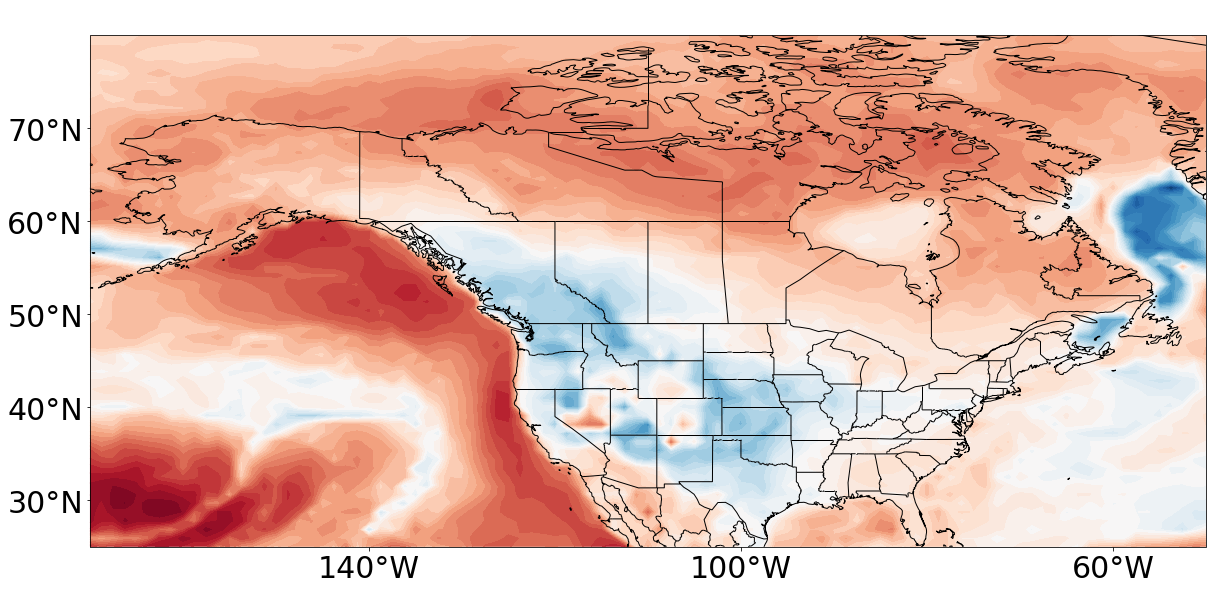

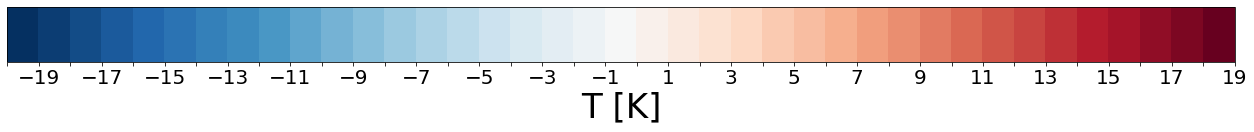

In [181]:
plot_field= HSS_map.squeeze()

plt.figure(figsize=(20, 20))
proj = ccrs.PlateCarree(central_longitude=180)
ax1 = plt.subplot(1, 1, 1, projection=proj)
ax1.coastlines('50m')

clevsHSS=np.arange(-20,20,1) 

haa = cm.get_cmap("Greys",len(clevsHSS))
haa = haa(np.linspace(0,1,len(clevsHSS)))
white=[1,1,1,1]
haa[:3,:] = white

#either do this 
cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))

#or set an ocean nanmask! 
nanmask = np.zeros_like(plot_field)+1


plt.contourf(lon-180, lat, (plot_field),levels=clevsHSS,
            cmap=cmap, transform=proj)


plt.plot([120-180,300-180],[0,0],color='k',linewidth=1,linestyle='--',zorder=1)

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')

ax1.set_xticks([100,140,180,220,260,300,340], crs=ccrs.PlateCarree())
ax1.set_yticks(np.arange(-10,80,10), crs=ccrs.PlateCarree())

lon_formatter = LongitudeFormatter(zero_direction_label=True,number_format='.0f')
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.tick_params(labelsize=30) 
ax1.set_extent([190,310,25,80], crs=ccrs.PlateCarree())
ax1.add_feature(states_provinces, edgecolor='black')
ax1.add_feature(cartopy.feature.BORDERS,edgecolor='black')
plt.title(' ',fontsize=30)
plt.show()


# ############################################################################################
#                                         ####colorbar#####
# ############################################################################################
fig, ax = plt.subplots(figsize=(22, 2))
fig.subplots_adjust(bottom=0.5)

#set these features the same as above. 
cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))
bounds=clevsHSS

norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal', extend='neither',
                                ticks=bounds)


cb2.ax.tick_params(labelsize=20) 
for label in cb2.ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
cb2.set_label('T [K]',fontsize=34) 
plt.show()


In [201]:
test_mean

-0.46480572

In [202]:
test_std

7.671736604647823

Low: 0.3988346272555827 Mid: 0.35945334898860526 High: 0.24171202375581202


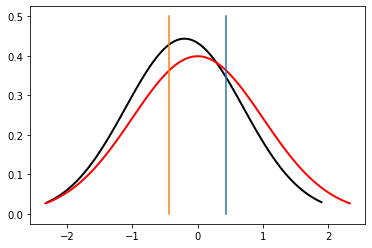

In [223]:

Training_mean=0
Training_std=1

test_mean=-.20
test_std=0.9

threethree = scipy.stats.norm.ppf(.333333, loc=Training_mean, scale=Training_std)
sixsix = scipy.stats.norm.ppf(.666666, loc=Training_mean, scale=Training_std)

x = np.linspace(scipy.stats.norm(test_mean, test_std).ppf(0.01),
                scipy.stats.norm(test_mean, test_std).ppf(0.99), 100)
rv = scipy.stats.norm(test_mean, test_std)
plt.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')


x = np.linspace(scipy.stats.norm(Training_mean,Training_std).ppf(0.01),
                scipy.stats.norm(Training_mean,Training_std).ppf(0.99), 100)
rv = scipy.stats.norm(Training_mean,Training_std)
plt.plot(x, rv.pdf(x), 'r-', lw=2, label='frozen pdf')
plt.plot([sixsix,sixsix],[0,0.5])
plt.plot([threethree,threethree],[0,0.5])


percHigh = scipy.stats.norm(test_mean, test_std).sf(sixsix)

percLow = (1-scipy.stats.norm(test_mean, test_std).sf(threethree))
        
percNeut = 1 - (1-scipy.stats.norm(test_mean, test_std).sf(threethree)) - scipy.stats.norm(test_mean, test_std).sf(sixsix)

print('Low:',percLow,'Mid:',percNeut,'High:',percHigh)


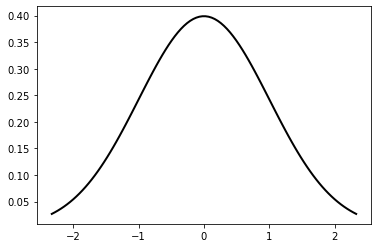

In [396]:
x = np.linspace(norm(0,1).ppf(0.01),
                norm(0,1).ppf(0.99), 100)
rv = norm(0,1)
plt.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')

In [321]:
for yes in range(len(DF_year)): 
    test_MJO = DF_year.iloc[yes]['MJO_INDEX']
    test_ENSO = DF_year.iloc[yes]['ENSO']
    
    if test_MJO > MJOthresh:
        MJO_test_mean = MJO_strong_mean 
    else:
        MJO_test_mean = MJO_weak_mean 
        
    if test_ENSO > ENSOthresh:
        ENSO_test_mean = Nino_mean
        ENSO_test_std = Nino_std
    elif test_ENSO < -ENSOthresh:
        ENSO_test_mean = Nina_mean
        ENSO_test_std = Nina_std
    else: 
        ENSO_test_mean = Neut_mean
        ENSO_test_std = Neut_std

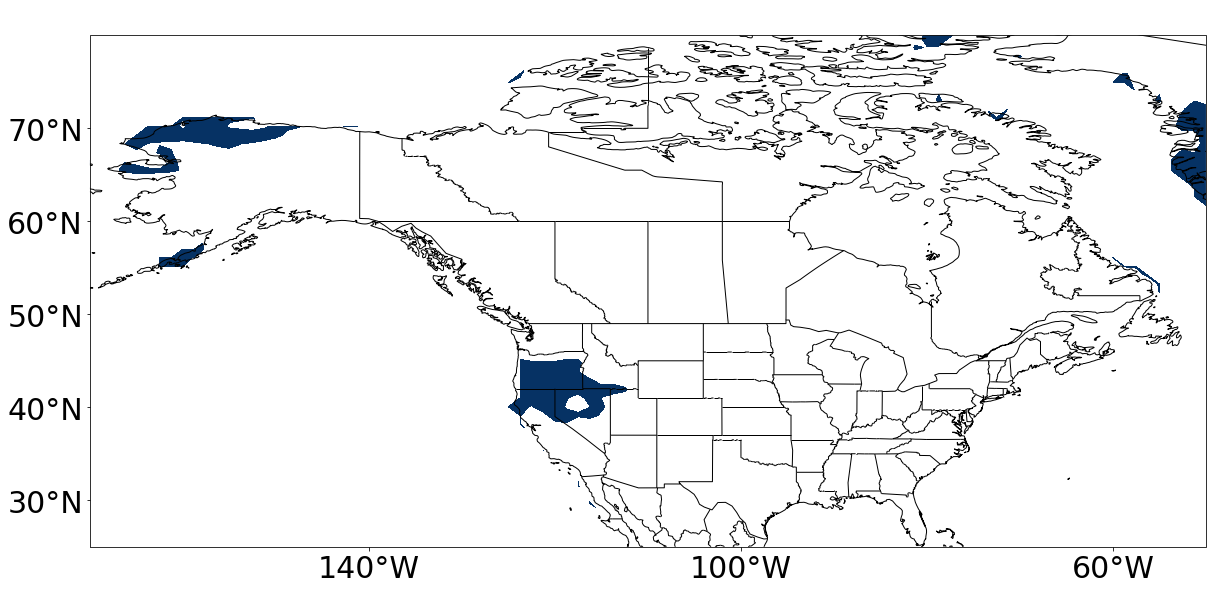

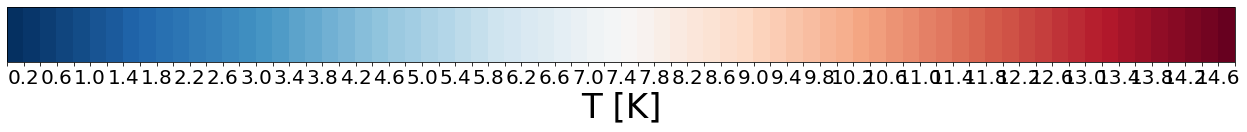

In [274]:
plot_field= Training_mean*LM

plt.figure(figsize=(20, 20))
proj = ccrs.PlateCarree(central_longitude=180)
ax1 = plt.subplot(1, 1, 1, projection=proj)
ax1.coastlines('50m')

clevsHSS=np.arange(0,15,0.2) 

haa = cm.get_cmap("Greys",len(clevsHSS))
haa = haa(np.linspace(0,1,len(clevsHSS)))
white=[1,1,1,1]
haa[:3,:] = white

#either do this 
cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))

#or set an ocean nanmask! 
nanmask = np.zeros_like(plot_field)+1


plt.contourf(lon-180, lat, (plot_field),levels=clevsHSS,
            cmap=cmap, transform=proj)


plt.plot([120-180,300-180],[0,0],color='k',linewidth=1,linestyle='--',zorder=1)

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')

ax1.set_xticks([100,140,180,220,260,300,340], crs=ccrs.PlateCarree())
ax1.set_yticks(np.arange(-10,80,10), crs=ccrs.PlateCarree())

lon_formatter = LongitudeFormatter(zero_direction_label=True,number_format='.0f')
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.tick_params(labelsize=30) 
ax1.set_extent([190,310,25,80], crs=ccrs.PlateCarree())
ax1.add_feature(states_provinces, edgecolor='black')
ax1.add_feature(cartopy.feature.BORDERS,edgecolor='black')
plt.title(' ',fontsize=30)
plt.show()


# ############################################################################################
#                                         ####colorbar#####
# ############################################################################################
fig, ax = plt.subplots(figsize=(22, 2))
fig.subplots_adjust(bottom=0.5)

#set these features the same as above. 
cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))
bounds=clevsHSS

norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal', extend='neither',
                                ticks=bounds)


cb2.ax.tick_params(labelsize=20) 
for label in cb2.ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
cb2.set_label('T [K]',fontsize=34) 
plt.show()
